# Cell State Dissection

Using ideas from the FineClustering analysis to dissect the major cell states in the data.

In [ ]:
library(SnapATAC)
library(reshape2)
library(viridis)
library(scales)
library(ggplot2)
library(ggrepel)
library(DESeq2)
library(ClusterR)
library(RColorBrewer)
library(patchwork)
library(cowplot)
library(edgeR)
library(rtracklayer)

In [2]:
qual_col_pals = brewer.pal.info[brewer.pal.info$category == 'qual',]
col_vector = unlist(mapply(brewer.pal, qual_col_pals$maxcolors, rownames(qual_col_pals)))

In [4]:
DAYS = c()
FILE_PREFIX = "/srv/scratch/surag/scATAC-reprog/snap"

file.list = c()
barcode.file.list = c()

for (i in seq(0, 14, 2)) {
    DAYS = c(DAYS, sprintf("D%d", i))
    file.list = c(file.list, sprintf("%s/D%d.snap", FILE_PREFIX, i))
}
DAYS
file.list

[1] "D0"  "D2"  "D4"  "D6"  "D8"  "D10" "D12" "D14"

[1] "/srv/scratch/surag/scATAC-reprog/snap/D0.snap" 
[2] "/srv/scratch/surag/scATAC-reprog/snap/D2.snap" 
[3] "/srv/scratch/surag/scATAC-reprog/snap/D4.snap" 
[4] "/srv/scratch/surag/scATAC-reprog/snap/D6.snap" 
[5] "/srv/scratch/surag/scATAC-reprog/snap/D8.snap" 
[6] "/srv/scratch/surag/scATAC-reprog/snap/D10.snap"
[7] "/srv/scratch/surag/scATAC-reprog/snap/D12.snap"
[8] "/srv/scratch/surag/scATAC-reprog/snap/D14.snap"

In [5]:
x.sp.ls = lapply(seq(file.list), function(i) {
    x.sp = createSnap(file = file.list[i],                      
                     sample = DAYS[i])
    x.sp
})

Epoch: reading the barcode session ...

Epoch: reading the barcode session ...

Epoch: reading the barcode session ...

Epoch: reading the barcode session ...

Epoch: reading the barcode session ...

Epoch: reading the barcode session ...

Epoch: reading the barcode session ...

Epoch: reading the barcode session ...



In [6]:
# Metadata file from previous run
# should contain, sample_barcode as rowname, sample, umap1, umap2, cluster
metaData = read.table("../20200206_pmat_snapATAC/sessions/20200220_n74838/metadata.tsv", header = T)
metaData$barcode = lapply(strsplit(rownames(metaData), '_'), "[[", 2)
metaData = metaData[order(rownames(metaData)), ]
head(metaData, 2)

sample umap.1   umap.2    cluster barcode         
D0_AAACAACGACGATTAC D0     6.545686 -7.701751 2       AAACAACGACGATTAC
D0_AAACAACGACTCACGG D0     5.180663 -7.633298 2       AAACAACGACTCACGG

In [7]:
# Filter cells 
x.sp.list = lapply(seq(x.sp.ls), function(i){
  x.sp = x.sp.ls[[i]];
  x.sp  = x.sp[x.sp@barcode %in% metaData[as.character(metaData$sample)==DAYS[i], "barcode"],];
})
names(x.sp.list) = DAYS;

In [8]:
x.sp.list = lapply(seq(x.sp.list), function(i) {
    x.sp = addPmatToSnap(x.sp.list[[i]], num.cores=5)
    x.sp
})

Epoch: reading cell-peak count matrix session ...

Epoch: reading cell-peak count matrix session ...

Epoch: reading cell-peak count matrix session ...

Epoch: reading cell-peak count matrix session ...

Epoch: reading cell-peak count matrix session ...

Epoch: reading cell-peak count matrix session ...

Epoch: reading cell-peak count matrix session ...

Epoch: reading cell-peak count matrix session ...



In [9]:
# merge timepoints
x.sp = Reduce(snapRbind, x.sp.list);

Warning message:
“'rBind' is deprecated.
 Since R version 3.2.0, base's rbind() should work fine with S4 objects”


In [10]:
# order by sample_barcode
x.sp = x.sp[order(paste(x.sp@sample, x.sp@barcode, sep='_')), ]

In [11]:
# Note that the peaks matrix is not binarized

In [12]:
x.sp@cluster = factor(metaData$cluster)
slot(x.sp, "umap") = as.matrix(metaData[, c("umap.1", "umap.2")])

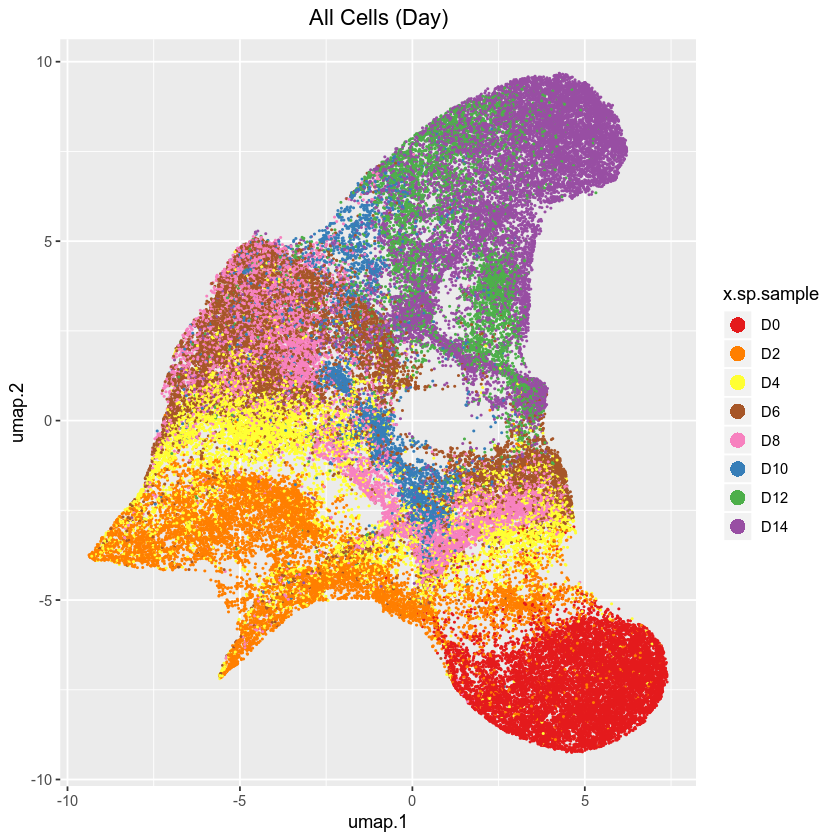

In [13]:
options(repr.plot.width = 7, repr.plot.height = 7)

df = data.frame(x.sp@umap, x.sp@sample)
# shuffle so days don't overlap
df = df[sample(dim(df)[1]), ]

ggplot(df) +
# ggplot(df[df$x.sp.sample %in% c("D10", "D12"), ]) +
geom_point(size=0.2, alpha=1, aes(x=umap.1 , y=umap.2, col=x.sp.sample)) +
scale_color_brewer(breaks=DAYS, palette = "Set1") +
ggtitle("All Cells (Day)") + 
theme(plot.title = element_text(hjust = 0.5)) + 
guides(colour = guide_legend(override.aes = list(shape=16, alpha=1, size=4))) 

## Finer Clustering

In [14]:
library(RANN)
library(leiden)

In [15]:
feats = read.table("../20200206_pmat_snapATAC/sessions/20200220_n74838/features.tsv", header = T)
feats = feats[order(rownames(feats)),]
feats = feats[, 5:ncol(feats)]
head(feats,3)

X1           X2          X3          X4          
D0_AAACAACGACGATTAC -0.009506306 0.003827220 0.004101834 -0.009462710
D0_AAACAACGACTCACGG -0.009003734 0.002892498 0.004525334 -0.004391663
D0_AAACAACGAGCGCACT -0.009416234 0.003781612 0.004398451 -0.006866973
                    X5           X6           X7          X8         
D0_AAACAACGACGATTAC 0.0016989356 -0.006388548 0.004262987 0.003578299
D0_AAACAACGACTCACGG 0.0009756110 -0.010070413 0.005721408 0.003989271
D0_AAACAACGAGCGCACT 0.0005773408 -0.007889277 0.005984896 0.004210641
                    X9           
D0_AAACAACGACGATTAC -0.0055907033
D0_AAACAACGACTCACGG  0.0005145822
D0_AAACAACGAGCGCACT -0.0032638603

In [16]:
K = 15

nn.ranked <- nn2(
        data = feats,
        k = K,
        searchtype = 'standard',
        eps = 0)$nn.idx;

j <- as.numeric(x = t(x = nn.ranked))
i <- ((1:length(x = j)) - 1) %/% K + 1
edgeList = data.frame(i, j, 1);
kmat = Matrix(0, nrow(feats), nrow(feats), sparse=TRUE);
kmat = sparseMatrix(i = edgeList[,1], j = edgeList[,2], x = edgeList[,3]);
nn_graph = SnapATAC:::newKgraph(mat=kmat, k=K, snn=FALSE, snn.prune=1/15);

In [17]:
clusters = leiden(SnapATAC:::getGraph(nn_graph), resolution=2)

In [18]:
table(clusters)

clusters
   1    2    3    4    5    6    7    8    9   10   11   12   13   14   15   16 
3862 3690 3559 3260 3160 3039 2917 2742 2668 2625 2586 2522 2504 2485 2466 2461 
  17   18   19   20   21   22   23   24   25   26   27   28   29   30   31   32 
2445 2256 2151 2067 1941 1836 1829 1763 1758 1666 1663 1640 1282 1247 1113  859 
  33 
 776 

In [1928]:
# write fine clusters to file
# df = data.frame(sample_barcode=paste(x.sp@sample, x.sp@barcode, sep='_'), 
#                 clusters)
# write.table(df, "../20200206_pmat_snapATAC/sessions/20200220_n74838/fine_clusters.tsv", 
#             row.names = F, 
#             quote = F)

In [21]:
# load fine clusters from file
fine_clusters = read.table("../20200206_pmat_snapATAC/sessions/20200220_n74838/fine_clusters.tsv", 
            header = T)
all(fine_clusters$sample_barcode==rownames(metaData))

clusters = fine_clusters$clusters
head(fine_clusters)

[1] TRUE

sample_barcode      clusters
1 D0_AAACAACGACGATTAC  1      
2 D0_AAACAACGACTCACGG 18      
3 D0_AAACAACGAGCGCACT 14      
4 D0_AAACAACGATGGAACG 18      
5 D0_AAACACGCTACGCCAC 14      
6 D0_AAACACGCTAGACTTC 14

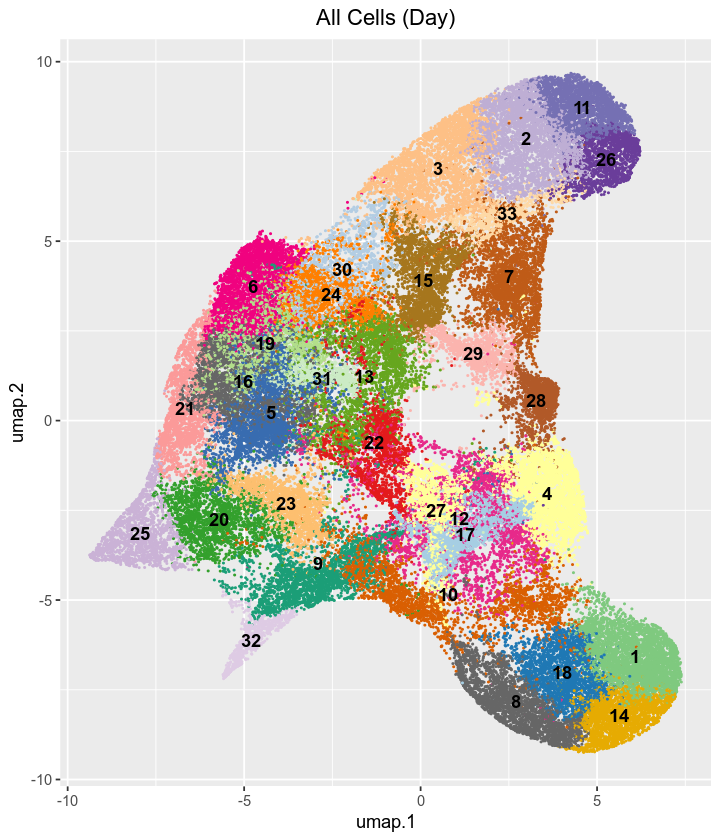

In [22]:
options(repr.plot.width = 6, repr.plot.height = 7)

df = data.frame(x.sp@umap, clst=as.factor(clusters))
# shuffle so days don't overlap
df = df[sample(dim(df)[1]), ]

ggplot(df) +
# ggplot(df[df$x.sp.sample %in% c("D14"), ]) +
geom_point(size=0.2, alpha=1, aes(x=umap.1 , y=umap.2, col=clst)) +
# scale_color_brewer( palette = "Set1") +
scale_color_manual(values=col_vector) +
geom_text(data=data.frame(aggregate(x.sp@umap, list(clusters), mean)),
         aes(x=umap.1, y=umap.2, label=Group.1), fontface = "bold") +
ggtitle("All Cells (Day)") + 
theme(plot.title = element_text(hjust = 0.5),
      legend.positio = "none")
# guides(colour = guide_legend(override.aes = list(shape=16, alpha=1, size=4))) 

In [23]:
table(x.sp@sample[clusters=="4"])


  D0  D10  D12  D14   D2   D4   D6   D8 
  15    4   37   38   74  832 1445  815 

## Make pseudo-bulk matrix

In [20]:
agg_matrix = sparseMatrix(i=clusters,
                         j=seq(1,nrow(x.sp)),
                         x=1L,
                         dims=c(length(table(clusters)), nrow(x.sp)))

In [21]:
cts = as.matrix(agg_matrix %*% x.sp@pmat)
colnames(cts) = as.character(x.sp@peak)
rownames(cts) = paste("cluster", seq(1,nrow(cts)), sep="_")
cts = t(cts)
head(cts)

cluster_1 cluster_2 cluster_3 cluster_4 cluster_5 cluster_6
chr1:16147-16347    7         9         7         5        16         5       
chr1:51459-51659    0         3         0         0         1         0       
chr1:51689-52109    1        13        18         0         3         2       
chr1:180686-181260 47        29        21        25        67        31       
chr1:181268-181597 30        54        21        10        66        35       
chr1:184385-184585 11         7        10         5        30        10       
                   cluster_7 cluster_8 cluster_9 cluster_10 ⋯ cluster_24
chr1:16147-16347    5        14         6         0         ⋯  6        
chr1:51459-51659    1         1         0         0         ⋯  0        
chr1:51689-52109    6         1         0         0         ⋯  0        
chr1:180686-181260 35        52        11         8         ⋯ 23        
chr1:181268-181597 54        29        27        10         ⋯ 18        
chr1:184385-184585 13         9        12        13         ⋯  7        
                   cluster_25 cluster_26 cluster_27 cluster_28 cluster_29
chr1:16147-16347    0          2          3         2          1         
chr1:51459-51659    0          0          0         1          0         
chr1:51689-52109    0          1          0         0          0         
chr1:180686-181260 16         18         15         3          5         
chr1:181268-181597 16         20         26         5          8         
chr1:184385-184585  4          0         10         2          5         
                   cluster_30 cluster_31 cluster_32 cluster_33
chr1:16147-16347    6          8          0          0        
chr1:51459-51659    2          0          0          0        
chr1:51689-52109    3          2          0          0        
chr1:180686-181260 28         27          1          9        
chr1:181268-181597 35         33         15         11        
chr1:184385-184585  9         24          5          0

In [22]:
cts = cts[rowSums(cts)>50, ]
dim(cts)

[1] 457477     33

In [23]:
norm_cts = t(t(cts)/estimateSizeFactorsForMatrix(cts))

In [24]:
log_norm_cts = log2(1+norm_cts)

## Clustering etc

In [25]:
PLOT_CLSTS = colnames(norm_cts) #c("cluster_1", "cluster_10", "cluster_26", "cluster_6")
CLST_BASIS = PLOT_CLSTS
# CLST_BASIS = c("cluster_1", "cluster_10", "cluster_26")
cts_to_cluster = log2(1+200*(norm_cts/width(GRanges(rownames(norm_cts)))))
# cts_to_cluster = t(scale(t(log_norm_cts)))

In [634]:
# ADD RAND SEED - not required

km_mb = MiniBatchKmeans(cts_to_cluster[,CLST_BASIS], 
                        batch_size = 1000,
                        clusters=15,
                        num_init = 10, 
                        verbose = FALSE)

In [635]:
# reorder based on hierarchical clustering
# pr_mb = predict_MBatchKMeans(cts_to_cluster, km_mb$centroids)

# distance    = dist(t(scale(t(km_mb$centroids))))
# cluster     = hclust(distance, method="ward")
# dendrogram  = as.dendrogram(cluster)
# rowInd = rev(order.dendrogram(dendrogram))
# pr_mb = order(rowInd)[pr_mb]

In [636]:
# no hierarchical clustering, follow order of km_mb$centroids
pr_mb = predict_MBatchKMeans(cts_to_cluster[, CLST_BASIS], km_mb$centroids)

In [637]:
table(pr_mb)

pr_mb
    1     2     3     4     5     6     7     8     9    10    11    12    13 
15686 38535 21933 24700 33405 35399 44535 17831 22244 32609 34596 33936 38920 
   14    15 
29954 33194 

In [638]:
order(rowVars(km_mb$centroids))

[1]  5  1  2  6 15 11 14 12 13  7 10  4  3  9  8

In [639]:
cts_clustered = cts_to_cluster[order(pr_mb),]
head(cts_clustered, 2)

cluster_1 cluster_2 cluster_3 cluster_4 cluster_5 cluster_6
chr1:633905-634268 5.799924  5.906914  8.055269  9.533027  8.212103  9.915293 
chr1:778297-778948 7.199558  7.191567  6.630632  6.497154  6.675978  6.256913 
                   cluster_7 cluster_8 cluster_9 cluster_10 ⋯ cluster_25
chr1:633905-634268 6.174999  8.095988  8.530713  7.099929   ⋯ 8.131771  
chr1:778297-778948 7.309356  6.366978  6.313137  6.759074   ⋯ 6.517724  
                   cluster_26 cluster_27 cluster_28 cluster_29 cluster_30
chr1:633905-634268 7.870408   7.796643   8.667458   7.257731   8.260799  
chr1:778297-778948 6.647489   6.840683   6.621128   6.535793   6.675498  
                   cluster_31 cluster_32 cluster_33 cluster_34
chr1:633905-634268 7.340751   6.528611   7.292625   7.803046  
chr1:778297-778948 6.955355   6.737744   6.353300   6.494609

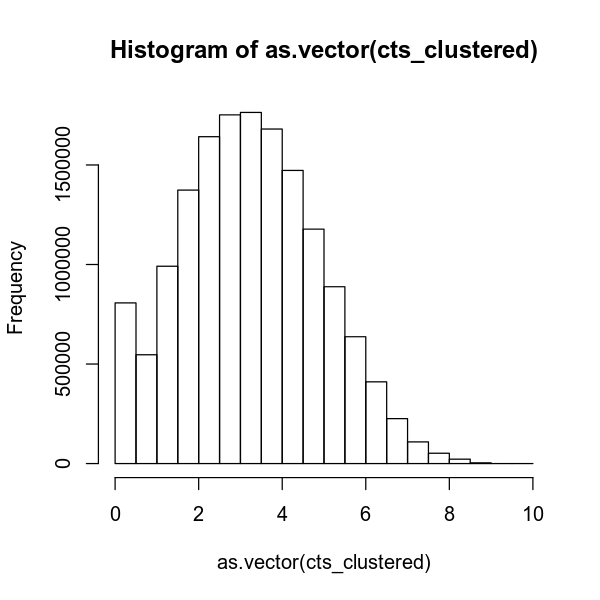

In [640]:
options(repr.plot.width = 5, repr.plot.height = 5)
hist(as.vector(cts_clustered))

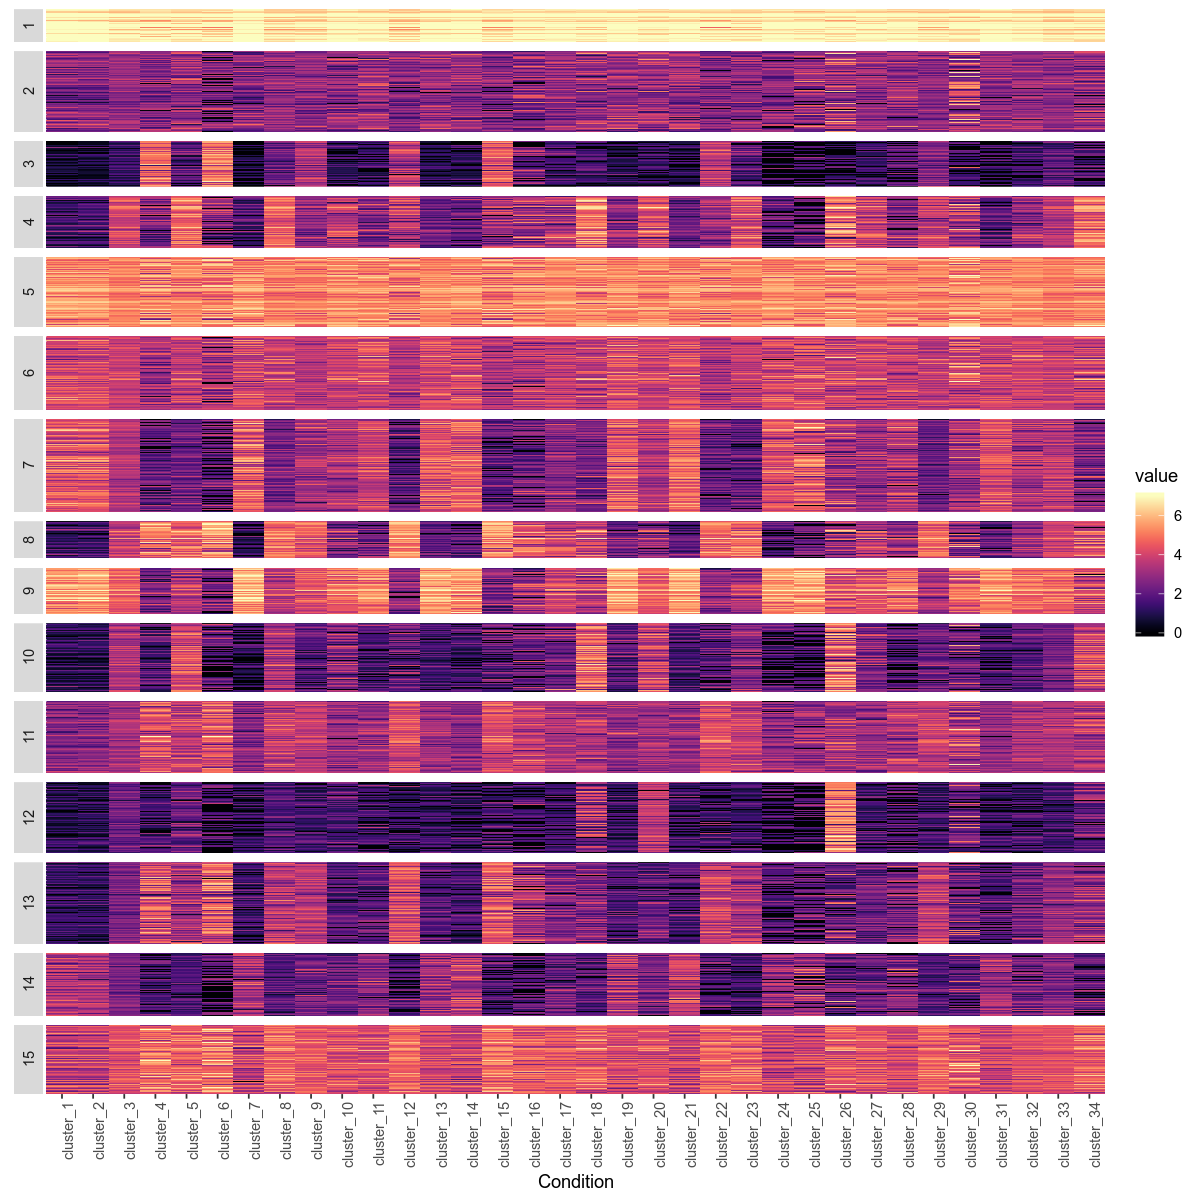

In [645]:
options(repr.plot.width = 10, repr.plot.height = 10)

idxs = seq(1, nrow(cts_clustered), 10) # if subsample
ggplot(data = melt(cts_clustered[idxs, ]), 
       mapping = aes(x = Var2,
                     y = Var1,
                     fill = value)) +
geom_tile()  + ylab(NULL) + xlab("Condition") +  
geom_raster(aes(fill=value)) +
scale_fill_viridis(limits=c(0, 7), oob=squish, option = "A") +
# scale_fill_viridis(option="A") + 
# scale_fill_gradient2(low="red", mid="black", high="blue") +
facet_grid(sort(pr_mb)[idxs] ~ ., switch = "y", scales = "free_y", space = "free_y")+
# theme_classic() +
theme(axis.text.x=element_text(angle=90,hjust=1),
      axis.text.y=element_blank(),
      axis.ticks.y=element_blank()) 
#       panel.spacing.y = unit(0.03, "cm"),
#       strip.text.y = element_text(size = 3))  
#       strip.background = element_rect(size = 0.1))

# ggsave(sprintf("figs/%s_tmp_heatmap_n%d.jpeg", format(Sys.Date(), format='%Y%m%d'), length(table(pr_mb))),
#        dpi=1000)

In [360]:
CLUSTER_IDX = 1
NORM = 'tmp'
BED_PATH = sprintf("beds/%s_%s_n%d/idx%d.bed", format(Sys.Date(), format='%Y%m%d'), NORM, length(table(pr_mb)), CLUSTER_IDX)
# rownames(vsd_assay_to_cluster_normalized)[(which(pr_mb==CLUSTER_IDX))]
BED_PATH

[1] "beds/20200328_tmp_n20/idx1.bed"

In [361]:
for (i in seq(1,length(table(pr_mb)))){
BED_PATH = sprintf("beds/%s_%s_n%d/idx%d.bed", format(Sys.Date(), format='%Y%m%d'), NORM, length(table(pr_mb)), i)
fileConn = file(BED_PATH)
writeLines(sub('-', '\t', sub(':', '\t', rownames(cts_to_cluster)))[(which(pr_mb==i))], fileConn)
close(fileConn)}

In [362]:
ALL_PEAKS_BED_PATH = sprintf("beds/%s_%s_n%d/all_peaks.bed", format(Sys.Date(), format='%Y%m%d'), NORM, length(table(pr_mb)))
print(ALL_PEAKS_BED_PATH)
fileConn = file(ALL_PEAKS_BED_PATH)
writeLines(sub('-', '\t', sub(':', '\t', rownames(cts_to_cluster))), fileConn)
close(fileConn)

[1] "beds/20200328_tmp_n20/all_peaks.bed"


## Gene Scores

In [2134]:
gencode.basic.hg38 = import.gff(gzfile("../../../resources/GENCODE/gencode.v33.chr_patch_hapl_scaff.basic.annotation.gtf.gz"))
gencode.basic.hg38 = keepStandardChromosomes(gencode.basic.hg38, pruning.mode = "coarse")
gencode.basic.tx.hg38 = subset(subset(gencode.basic.hg38, gene_type=="protein_coding"), type=="transcript")
head(gencode.basic.tx.hg38, 3)
length(gencode.basic.tx.hg38)

Warning message in readGFF(filepath, version = version, filter = filter):
"connection is not positioned at the start of the file, rewinding it"


GRanges object with 3 ranges and 21 metadata columns:
      seqnames        ranges strand |   source       type     score     phase
         <Rle>     <IRanges>  <Rle> | <factor>   <factor> <numeric> <integer>
  [1]     chr1   65419-71585      + |   HAVANA transcript      <NA>      <NA>
  [2]     chr1   69055-70108      + |  ENSEMBL transcript      <NA>      <NA>
  [3]     chr1 450703-451697      - |   HAVANA transcript      <NA>      <NA>
                gene_id      gene_type   gene_name       level     hgnc_id
            <character>    <character> <character> <character> <character>
  [1] ENSG00000186092.6 protein_coding       OR4F5           2  HGNC:14825
  [2] ENSG00000186092.6 protein_coding       OR4F5           3  HGNC:14825
  [3] ENSG00000284733.1 protein_coding      OR4F29           2  HGNC:31275
               havana_gene     transcript_id transcript_type transcript_name
               <character>       <character>     <character>     <character>
  [1] OTTHUMG00000001094.4 

[1] 58073

In [2278]:
tx.hg38 = gencode.basic.tx.hg38

In [2279]:
tss.hg38 = unique(resize(tx.hg38, width=1, fix='start'))
tss.hg38

GRanges object with 51948 ranges and 21 metadata columns:
          seqnames    ranges strand |   source       type     score     phase
             <Rle> <IRanges>  <Rle> | <factor>   <factor> <numeric> <integer>
      [1]     chr1     65419      + |   HAVANA transcript      <NA>      <NA>
      [2]     chr1     69055      + |  ENSEMBL transcript      <NA>      <NA>
      [3]     chr1    451697      - |   HAVANA transcript      <NA>      <NA>
      [4]     chr1    686673      - |   HAVANA transcript      <NA>      <NA>
      [5]     chr1    925731      + |   HAVANA transcript      <NA>      <NA>
      ...      ...       ...    ... .      ...        ...       ...       ...
  [51944]     chrM     10470      + |  ENSEMBL transcript      <NA>      <NA>
  [51945]     chrM     10760      + |  ENSEMBL transcript      <NA>      <NA>
  [51946]     chrM     12337      + |  ENSEMBL transcript      <NA>      <NA>
  [51947]     chrM     14673      - |  ENSEMBL transcript      <NA>      <NA>
  [519

In [2182]:
prom.hg38 = promoters(tss.hg38, upstream = 100, downstream = 100)
prom.hg38

GRanges object with 51948 ranges and 21 metadata columns:
          seqnames        ranges strand |   source       type     score
             <Rle>     <IRanges>  <Rle> | <factor>   <factor> <numeric>
      [1]     chr1   65319-65518      + |   HAVANA transcript      <NA>
      [2]     chr1   68955-69154      + |  ENSEMBL transcript      <NA>
      [3]     chr1 451598-451797      - |   HAVANA transcript      <NA>
      [4]     chr1 686574-686773      - |   HAVANA transcript      <NA>
      [5]     chr1 925631-925830      + |   HAVANA transcript      <NA>
      ...      ...           ...    ... .      ...        ...       ...
  [51944]     chrM   10370-10569      + |  ENSEMBL transcript      <NA>
  [51945]     chrM   10660-10859      + |  ENSEMBL transcript      <NA>
  [51946]     chrM   12237-12436      + |  ENSEMBL transcript      <NA>
  [51947]     chrM   14574-14773      - |  ENSEMBL transcript      <NA>
  [51948]     chrM   14647-14846      + |  ENSEMBL transcript      <NA>
      

In [2183]:
unique_prom_genes = names(table(prom.hg38$gene_name)[which(table(prom.hg38$gene_name)==1)])

In [2146]:
intervals_gr = GRanges(rownames(cts))

### Promoters Only

In [2184]:
overlaps = findOverlaps(prom.hg38, intervals_gr)
overlaps

Hits object with 42339 hits and 0 metadata columns:
          queryHits subjectHits
          <integer>   <integer>
      [1]         5          53
      [2]         5          54
      [3]         6          53
      [4]         6          54
      [5]         7          70
      ...       ...         ...
  [42335]     51883      457451
  [42336]     51884      457451
  [42337]     51885      457451
  [42338]     51886      457466
  [42339]     51887      457466
  -------
  queryLength: 51948 / subjectLength: 457477

In [2185]:
summed_gene = aggregate(cts[subjectHits(overlaps),], list(queryHits(overlaps)), sum)

rownames(summed_gene) = prom.hg38[summed_gene$Group.1]$transcript_name
summed_gene$Group.1 = NULL

# DESeq2 normalize
summed_gene = as.data.frame(t(t(summed_gene)/estimateSizeFactorsForMatrix(summed_gene)))

head(summed_gene)

cluster_1 cluster_2 cluster_3 cluster_4 cluster_5 cluster_6
SAMD11-202  110.31572 105.81123 110.57988 160.19735 147.37514 176.30263
SAMD11-213  110.31572 105.81123 110.57988 160.19735 147.37514 176.30263
NOC2L-201   294.46141 244.17977 199.45716 302.52882 262.46810 262.40391
KLHL17-201  188.43813 134.88025 115.74716 185.20958 183.58731 185.67420
KLHL17-205  188.43813 134.88025 115.74716 185.20958 183.58731 185.67420
PLEKHN1-203  56.66021  89.53258  82.67654  83.37409  95.44295  79.07261
            cluster_7 cluster_8 cluster_9 cluster_10 ⋯ cluster_24 cluster_25
SAMD11-202  121.28157 102.72393 174.8265  129.9930   ⋯ 153.19003  198.69263 
SAMD11-213  121.28157 102.72393 174.8265  129.9930   ⋯ 153.19003  198.69263 
NOC2L-201   224.57082 323.09749 263.0567  250.4743   ⋯ 247.14658  267.24740 
KLHL17-201  154.60068 196.66804 192.7993  198.1600   ⋯ 168.50903  209.15014 
KLHL17-205  154.60068 196.66804 192.7993  198.1600   ⋯ 168.50903  209.15014 
PLEKHN1-203  86.62969  82.09135 138.8808  147.4310   ⋯  68.42488   90.63173 
            cluster_26 cluster_27 cluster_28 cluster_29 cluster_30 cluster_31
SAMD11-202  164.55205  103.1329   170.7918   171.91903  149.87990  114.6575  
SAMD11-213  164.55205  103.1329   170.7918   171.91903  149.87990  114.6575  
NOC2L-201   258.12086  314.5127   240.3736   256.37048  267.64267  270.6381  
KLHL17-201  200.04367  211.3798   132.8381   144.77392  173.76186  194.3939  
KLHL17-205  200.04367  211.3798   132.8381   144.77392  173.76186  194.3939  
PLEKHN1-203  87.11579  127.8507   113.8612    93.49982   97.17488  108.8373  
            cluster_32 cluster_33
SAMD11-202  320.9393    91.43917 
SAMD11-213  320.9393    91.43917 
NOC2L-201   238.9214   298.38044 
KLHL17-201  274.5814   202.12869 
KLHL17-205  274.5814   202.12869 
PLEKHN1-203 153.3376    67.37623

### Gene Body

In [2307]:
overlaps = findOverlaps(tx.hg38+100, intervals_gr)
overlaps

Hits object with 779106 hits and 0 metadata columns:
           queryHits subjectHits
           <integer>   <integer>
       [1]         5          53
       [2]         5          54
       [3]         5          55
       [4]         5          56
       [5]         5          57
       ...       ...         ...
  [779102]     58001      457451
  [779103]     58002      457450
  [779104]     58002      457451
  [779105]     58003      457466
  [779106]     58004      457466
  -------
  queryLength: 58073 / subjectLength: 457477

In [2311]:
gene_body_summed = aggregate(cts[subjectHits(overlaps),], list(queryHits(overlaps)), sum)

rownames(gene_body_summed) = tx.hg38[gene_body_summed$Group.1]$transcript_name
gene_body_summed$Group.1 = NULL

# DESeq2 normalize
gene_body_summed = as.data.frame(t(t(gene_body_summed)/estimateSizeFactorsForMatrix(gene_body_summed)))

# only keep those with a peak at the TSS
gene_body_summed = gene_body_summed[rownames(gene_body_summed) %in% rownames(summed_gene), ]

head(gene_body_summed)

cluster_1 cluster_2 cluster_3 cluster_4 cluster_5 cluster_6
SAMD11-202  1701.1117 753.8465  729.0371  1635.1310 1391.6471 1100.6873
SAMD11-213  1701.1117 753.8465  729.0371  1635.1310 1391.6471 1100.6873
NOC2L-201    876.2877 372.3266  330.2820   748.9630  557.4963  434.8870
KLHL17-201   205.3872 133.3021  112.7792   195.7374  182.5752  174.2847
KLHL17-205   205.3872 133.3021  112.7792   195.7374  182.5752  174.2847
PLEKHN1-203  376.6213 305.6756  263.8228   471.4061  417.0754  318.8804
            cluster_7 cluster_8 cluster_9 cluster_10 ⋯ cluster_24 cluster_25
SAMD11-202  1181.5372 1333.3497 1693.9187 1608.0198  ⋯ 1212.3000  1435.2681 
SAMD11-213  1181.5372 1333.3497 1693.9187 1608.0198  ⋯ 1212.3000  1435.2681 
NOC2L-201    453.1106  699.7987  571.9304  654.3884  ⋯  437.5451   531.5419 
KLHL17-201   153.9116  209.0065  191.1835  205.5240  ⋯  170.6736   188.7131 
KLHL17-205   153.9116  209.0065  191.1835  205.5240  ⋯  170.6736   188.7131 
PLEKHN1-203  362.8865  424.0780  623.7768  660.9652  ⋯  318.5908   376.3778 
            cluster_26 cluster_27 cluster_28 cluster_29 cluster_30 cluster_31
SAMD11-202  811.9679   1349.7789  1652.8434  1621.0682  1047.0993  1179.4563 
SAMD11-213  811.9679   1349.7789  1652.8434  1621.0682  1047.0993  1179.4563 
NOC2L-201   392.5630    662.5257   606.1467   560.9019   411.1860   529.8515 
KLHL17-201  208.0248    211.4625   131.2276   147.9302   171.8024   188.6678 
KLHL17-205  208.0248    211.4625   131.2276   147.9302   171.8024   188.6678 
PLEKHN1-203 399.2735    554.2364   518.6616   483.8550   442.9409   451.3341 
            cluster_32 cluster_33
SAMD11-202  2722.6691  908.0740  
SAMD11-213  2722.6691  908.0740  
NOC2L-201    801.9743  443.8339  
KLHL17-201   259.4623  214.2646  
KLHL17-205   259.4623  214.2646  
PLEKHN1-203  892.9546  382.6154

### Inverse Distance Model

In [2157]:
distal_overlaps = findOverlaps(tss.hg38+100000, intervals_gr)
distal_overlaps

Hits object with 2362659 hits and 0 metadata columns:
            queryHits subjectHits
            <integer>   <integer>
        [1]         1           1
        [2]         1           2
        [3]         2           1
        [4]         2           2
        [5]         3           8
        ...       ...         ...
  [2362655]     51887      457465
  [2362656]     51887      457466
  [2362657]     51887      457467
  [2362658]     51887      457468
  [2362659]     51900      457474
  -------
  queryLength: 51948 / subjectLength: 457477

In [2159]:
distal_summed_gene = cts[subjectHits(distal_overlaps),]

gene_peak_coeff = 1000*(1+abs(mid(intervals_gr[subjectHits(distal_overlaps)]) - start(tss.hg38[queryHits(distal_overlaps)])))^(-0.7)

distal_summed_gene = aggregate(gene_peak_coeff * distal_summed_gene, list(queryHits(distal_overlaps)), sum)

# remove genes with duplicate entries
rownames(distal_summed_gene) = prom.hg38[distal_summed_gene$Group.1]$transcript_name
distal_summed_gene$Group.1 = NULL

# DESeq2 normalize
distal_summed_gene = as.data.frame(t(t(distal_summed_gene)/estimateSizeFactorsForMatrix(distal_summed_gene)))

head(distal_summed_gene, 2)

cluster_1 cluster_2 cluster_3 cluster_4 cluster_5 cluster_6 cluster_7
OR4F5-202 2.225685  24.13375  26.83020  1.606004  3.455544  2.946304  6.781340 
OR4F5-201 2.056428  20.98198  23.09302  1.527776  3.172579  2.649300  5.919439 
          cluster_8 cluster_9 cluster_10 ⋯ cluster_24 cluster_25 cluster_26
OR4F5-202 3.908937  2.535315  0          ⋯ 3.209782   0          7.398194  
OR4F5-201 3.657093  2.411821  0          ⋯ 3.053435   0          6.609293  
          cluster_27 cluster_28 cluster_29 cluster_30 cluster_31 cluster_32
OR4F5-202 1.334454   3.265969   1.584593   5.658004   3.880414   0         
OR4F5-201 1.269453   3.106885   1.507408   5.054667   3.536122   0         
          cluster_33
OR4F5-202 0         
OR4F5-201 0

In [2786]:
rownames(distal_summed_gene)[grep("^JAKMIP2-", rownames(distal_summed_gene))]

[1] "MAP2-201" "MAP2-202" "MAP2-203" "MAP2-205" "MAP2-207"

In [2808]:
GENE = "JAKMIP2-201"

In [2809]:
# distal_summed_gene[GENE, ]
summed_gene[GENE, ]

cluster_1 cluster_2 cluster_3 cluster_4 cluster_5 cluster_6
JAKMIP2-201 278.1501  401.1525  356.5426  214.986   344.156   409.4204 
            cluster_7 cluster_8 cluster_9 cluster_10 ⋯ cluster_24 cluster_25
JAKMIP2-201 347.8515  288.4172  193.6162  250.4743   ⋯ 375.8262   404.3569  
            cluster_26 cluster_27 cluster_28 cluster_29 cluster_30 cluster_31
JAKMIP2-201 377.5018   232.6883   272.0018   280.4995   261.0545   253.7596  
            cluster_32 cluster_33
JAKMIP2-201 167.6016   370.5693

In [2810]:
max(distal_summed_gene[GENE, ])/min(distal_summed_gene[GENE, ])
max(summed_gene[GENE, ])/min(summed_gene[GENE, ])
max(gene_body_summed[GENE, ])/min(gene_body_summed[GENE, ])

gid_txn = unlist(strsplit(GENE, ":"))
as.character(prom.hg38[prom.hg38$transcript_name==GENE]+1000)

[1] 3.768571

[1] 3.026236

[1] 5.632632

[1] "chr5:147781676-147783875:-"

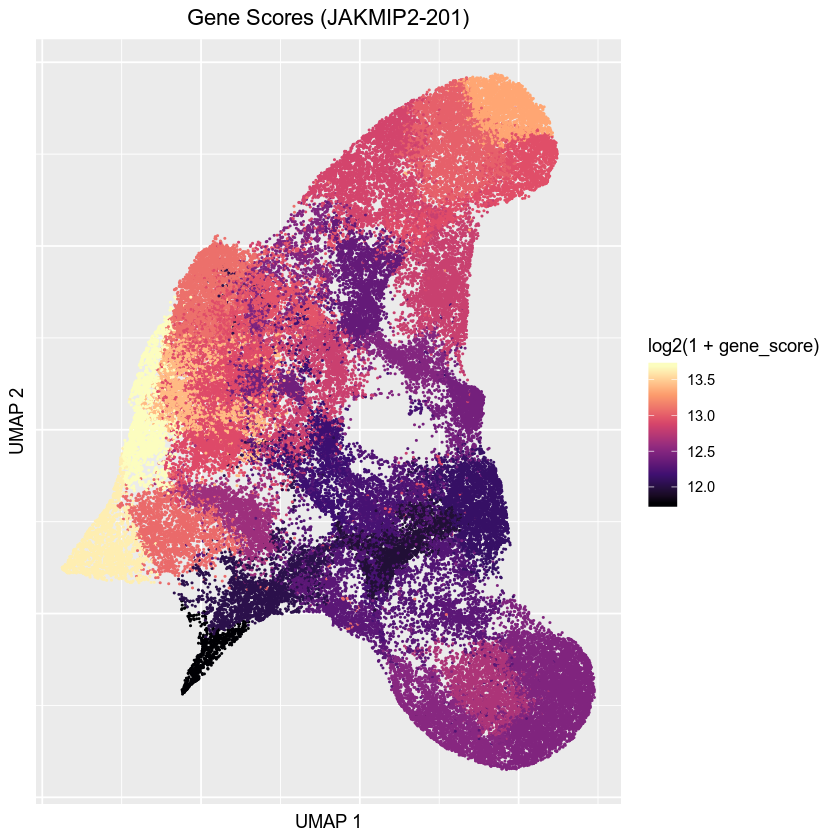

In [2812]:
options(repr.plot.width = 7, repr.plot.height = 7)

df = data.frame(x.sp@umap, gene_score=as.numeric(distal_summed_gene[GENE, ])[clusters])
# shuffle so days don't overlap
df = df[sample(dim(df)[1]), ]

ggplot(df) +
# ggplot(df[df$x.sp.sample %in% c("D14"), ]) +
geom_point(size=0.2, alpha=1, aes(x=umap.1 , y=umap.2, col=log2(1+gene_score))) +
ggtitle(sprintf("Gene Scores (%s)", GENE)) + 
xlab("UMAP 1") + ylab("UMAP 2") +
scale_color_viridis_c(oob=squish, option = "A") +
theme(plot.title = element_text(hjust = 0.5),
     axis.ticks = element_blank(),
     axis.text =element_blank())

## Cell State Dissection - Playground

In [1366]:
# load bulk RNA-seq data
fpkm = read.table("/users/surag/kundajelab/scATAC-reprog/resources/GSE62777/RNAseq.FPKM.tsv", sep='\t', header=T)
fpkm$gene_id = NULL
fpkm$locus=NULL
tpm = fpkm
tpm[,2:ncol(tpm)] = 1e6*t(t(tpm[,2:ncol(tpm)])/colSums(tpm[,2:ncol(tpm)]))

# removing genes with dup names
tpm = tpm[!duplicated(tpm$gene_short_name),]
rownames(tpm) = tpm$gene_short_name
tpm$gene_short_name = NULL

tpm["GAPDH",]

hiF.T_P14 X2dd_DOX_plus X5dd_DOX_plus X8dd_DOX_plus
GAPDH 7803.64   4963.505      3908.693      3839.776     
      X10dd_DOX_plus_SSEA3_pos X14dd_DOX_plus_SSEA3_pos X20dd_DOX_plus_TRA_plus
GAPDH 3795.548                 3364.503                 3032.412               
      X24dd_TRA_pos_DOX_plus X24dd_TRA_pos_DOX_minus hIPSC.T_P10
GAPDH 3790.955               5598.224                4731.256

In [2813]:
data.use = summed_gene
group = factor(colnames(data.use), levels = colnames(data.use))
y = DGEList(counts=data.use, group=group)

In [2814]:
design <- model.matrix(~0+group, data=y$samples)
colnames(design) <- levels(y$samples$group)

In [2815]:
fit <- glmFit(y, design, dispersion = 0.4^2)

In [2816]:
# contrast vector (one/many-vs-rest)
many = c("cluster_25")
cont = rep(-1/(ncol(data.use)-length(many)),ncol(data.use))
cont[(group %in% many)] = 1/length(many)

In [2432]:
# contrast vector (one/many-vs-one/many)
pos = c("cluster_6")
neg = c("cluster_30", "cluster_11", "cluster_2", "cluster_3") 
cont = rep(0,ncol(data.use))
cont[(group %in% pos)] = 1/length(pos)
cont[(group %in% neg)] = -1/length(neg)

In [2817]:
# one-vs-all for a cluster
lrt <- glmLRT(fit, contrast=cont)

In [2818]:
cur_diff_peaks = rownames(lrt$table[order((1/lrt$table$PValue)*ifelse(lrt$table$logFC>0, -1, 1)),])  

In [2819]:
head(cur_diff_peaks, 20)

[1] "DZANK1-202"  "ATP1A1-203"  "CDH2-202"    "GAB2-201"    "TMEM202-204"
 [6] "TMEM202-201" "TMEM202-202" "TESPA1-203"  "TESPA1-212"  "TESPA1-210" 
[11] "CCDC168-201" "MTCL1-207"   "CLDN22-201"  "RBM33-203"   "TSPAN8-201" 
[16] "TSPAN8-203"  "MIER3-205"   "ZHX3-201"    "ZHX3-218"    "ZHX3-217"

In [2398]:
length(rowMaxs(as.matrix(data.use[cur_diff_peaks, ])) == data.use[cur_diff_peaks, "cluster_6"])

[1] 38165

In [2450]:
# should be max in that cluster
head(cur_diff_peaks[rowMaxs(as.matrix(data.use[cur_diff_peaks, ])) == data.use[cur_diff_peaks, "cluster_21"]], 20)

[1] "SNRNP40-202" "EBLN2-201"   "IFNA14-201"  "TMEM174-201" "OMG-201"    
 [6] "PLAC8L1-201" "CCL7-201"    "MYBPC1-215"  "IFIT1B-201"  "LRRC37B-201"
[11] "LRRC37B-220" "LRRC37B-203" "LRRC37B-202" "DMKN-204"    "ZNF107-203" 
[16] "SLCO1A2-201" "TEX30-201"   "CADM2-202"   "LMOD2-202"   "LMOD2-201"

In [2220]:
# cur_diff_peaks = rownames(summed_gene)[rev(order(summed_gene[,"cluster_1"]/rowMeans(summed_gene)))]

In [2820]:
grep("^CDH2-", cur_diff_peaks)

[1]    3 2758

In [2383]:
# filter to those with unique TSS
head(cur_diff_peaks[lapply(strsplit(cur_diff_peaks, "-"), "[[", 1) %in% unique_prom_genes], 40)

[1] "PGK2-201"     "TMEM174-201"  "CLDN22-201"   "TRIM75P-201"  "GJB5-201"    
 [6] "GJB4-201"     "GDF3-201"     "DPPA2-201"    "OMG-201"      "FAAH2-201"   
[11] "GSTA1-201"    "TAF11L11-201" "KDM4E-201"    "GSTA2-201"    "PLA2G4F-202" 
[16] "APOBEC4-201"  "SLC35G4-201"  "CCDC179-202"  "CALHM1-201"   "ART1-201"    
[21] "ALPG-201"     "CLC-201"      "CD52-201"     "TACR3-201"    "CXCR1-201"   
[26] "CST2-201"     "TIAF1-201"    "RNF223-201"   "CDH10-201"    "IFIT1B-201"  
[31] "OR51S1-201"   "L1TD1-201"    "FBXO40-201"   "HOOK1-201"    "IDI2-201"    
[36] "NAP1L2-201"   "LCE3E-201"    "OLIG3-201"    "TFAP2C-201"   "KCNK1-202"

In [2384]:
# RNA-seq filter
cur_genes = lapply(strsplit(cur_diff_peaks, "-"), "[[", 1)
tpm_subset = data.frame(tpm[unlist(cur_genes[cur_genes %in% rownames(tpm)]), ])

rna_genes_subset = rownames(tpm_subset)[tpm_subset[,1]>1]
length(rna_genes_subset)

# For keratinocytes: initial increase-- rownames(tpm_subset)[((apply(tpm_subset[,c(1,1)], 1, max)<apply(tpm_subset[,2:3], 1, max)))]
# For immune response in non-OSKM: rownames(tpm_subset)[((apply(tpm_subset, 1, max)==apply(tpm_subset[,1:3], 1, max))  & (apply(tpm_subset, 1, max)>1))]

[1] 27141

In [2385]:
head(cur_diff_peaks[lapply(strsplit(cur_diff_peaks, "-"), "[[", 1) %in% rna_genes_subset], 40)

[1] "SNRNP40-202" "FLT1-208"    "CLDN22-201"  "ANO7-203"    "ZNF107-203" 
 [6] "SLCO1A2-201" "ZNF322-205"  "VASH1-204"   "EHMT1-216"   "EHMT1-211"  
[11] "IPO11-203"   "ZNF567-204"  "TIAF1-201"   "MBNL3-212"   "MBNL3-206"  
[16] "ATP1A1-203"  "IDI2-201"    "ZDBF2-202"   "KCNK1-202"   "CLSTN3-202" 
[21] "PPP1CC-204"  "SCML2-205"   "ASAP3-209"   "NBPF12-206"  "FOXP2-227"  
[26] "NFATC4-212"  "CD70-201"    "GALNT11-201" "MDM4-202"    "CAPZA2-214" 
[31] "CAPG-201"    "CAPG-205"    "CD70-202"    "GSDMB-202"   "GSDMB-203"  
[36] "EPHB1-211"   "LIME1-206"   "PTGFRN-201"  "FGF12-207"   "AUTS2-202"

In [2058]:
(cur_diff_peaks)[200]

[1] "FAM187A:NM_001258400"

In [2827]:
GENE = "GAB2-201"

In [2824]:
query = "^CDH2-"
rownames(data.use)[grepl(query, rownames(data.use))]
GENE = rownames(data.use)[grepl(query, rownames(data.use))][2]

[1] "CDH2-201" "CDH2-202"

In [2828]:
min(as.numeric(data.use[GENE, ]))
median(as.numeric(data.use[GENE, ]))
max(as.numeric(data.use[GENE, ]))
max(as.numeric(data.use[GENE, ]))/min(as.numeric(data.use[GENE, ]))
# data.use[GENE, ]

as.character(prom.hg38[prom.hg38$transcript_name==GENE, ]+1000)

[1] 0

[1] 6.213149

[1] 176.6157

[1] Inf

[1] "chr11:78340781-78342980:-"

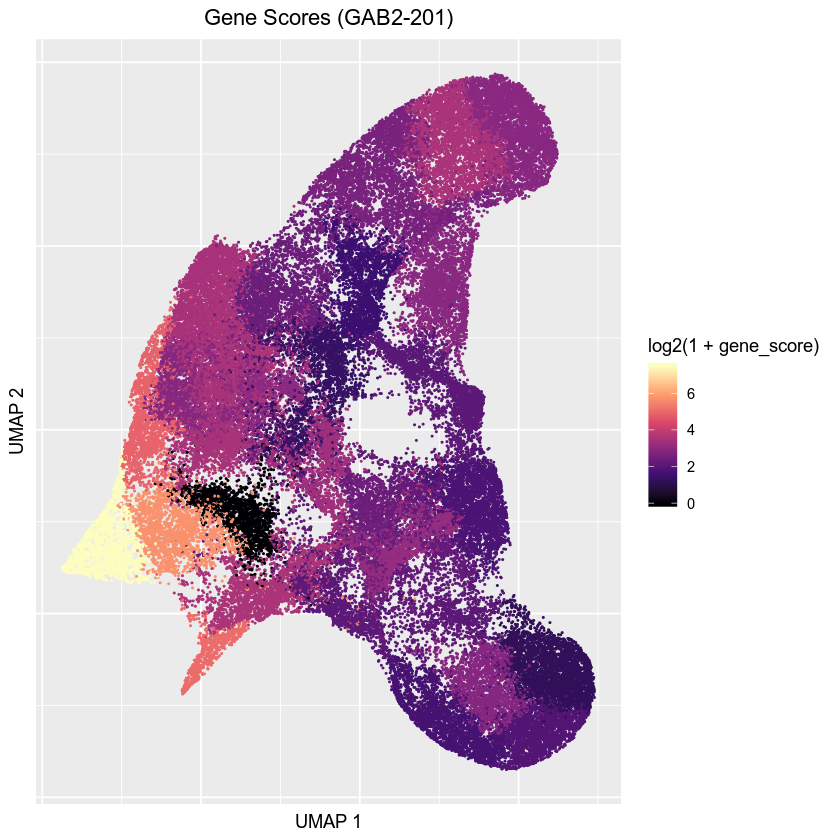

In [2829]:
options(repr.plot.width = 7, repr.plot.height = 7)

df = data.frame(x.sp@umap, gene_score=as.numeric(data.use[GENE, ])[clusters])
# shuffle so days don't overlap
df = df[sample(dim(df)[1]), ]

ggplot(df) +
# ggplot(df[df$x.sp.sample %in% c("D14"), ]) +
geom_point(size=0.2, alpha=1, aes(x=umap.1 , y=umap.2, col=log2(1+gene_score))) +
ggtitle(sprintf("Gene Scores (%s)", GENE)) + 
xlab("UMAP 1") + ylab("UMAP 2") +
scale_color_viridis_c(oob=squish, option = "A") +
theme(plot.title = element_text(hjust = 0.5),
     axis.ticks = element_blank(),
     axis.text =element_blank())

In [2533]:
ALL_PEAKS_BED_PATH = "tmp.bed"
fileConn = file(ALL_PEAKS_BED_PATH)

# write genes not in cur_diff_peaks
# cur_genes = lapply(strsplit(cur_diff_peaks, ":"), "[[", 1)
cur_genes = rna_genes_subset
remaining_genes = edb.genes.hg38$gene_name[!edb.genes.hg38$gene_name %in% cur_genes]
# writeLines(unique(c(unlist(cur_genes), remaining_genes)), fileConn)
# writeLines(unique(c(unlist(cur_genes))), fileConn)
writeLines(sub("-", "\t", sub(":", "\t", (cur_diff_peaks)[1:10000])), fileConn)

close(fileConn)

In [1594]:
ALL_PEAKS_BED_PATH = "tmp_all.txt"
fileConn = file(ALL_PEAKS_BED_PATH)
writeLines(edb.genes.hg38$gene_name, fileConn)
close(fileConn)

## Locus Level Analyses (Vignettes)
Analyses a bunch of gene clusters or regions to see aggregate signal in them. Usually doesn't work at single-cell level because regions are not large enough.

In [130]:
peaks_gr = GRanges(rownames(norm_cts))

### Type I Keratin Gene Cluster

Rough coordinates chr17:40801459-41629596. 

In [1403]:
region = "chr17:40801459-41629596"
region_gr = GRanges(c(region))

In [1404]:
norm_reads_in_region = colSums(norm_cts[unique(queryHits(findOverlaps(peaks_gr, region_gr))), ])

In [1405]:
max(norm_reads_in_region)
median(norm_reads_in_region)
min(norm_reads_in_region)
max(norm_reads_in_region)/min(norm_reads_in_region)

[1] 7182.931

[1] 2213.267

[1] 1769.294

[1] 4.059772

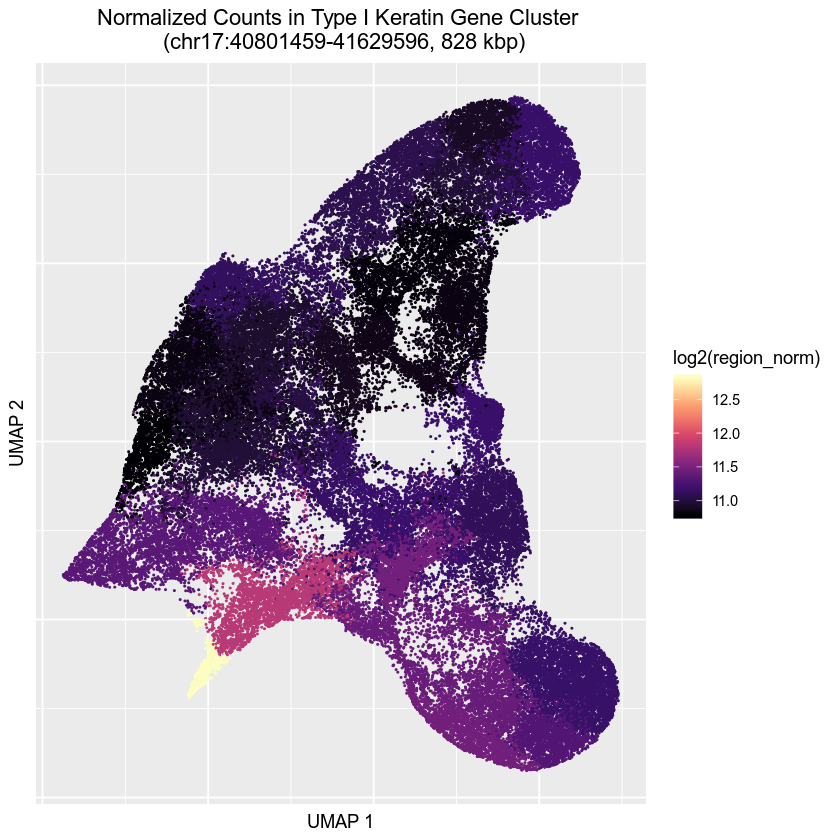

In [1406]:
options(repr.plot.width = 7, repr.plot.height = 7)

df = data.frame(x.sp@umap, region_norm=norm_reads_in_region[clusters])
# shuffle so days don't overlap
df = df[sample(dim(df)[1]), ]

ggplot(df) +
# ggplot(df[df$x.sp.sample %in% c("D14"), ]) +
geom_point(size=0.2, alpha=1, aes(x=umap.1 , y=umap.2, col=log2(region_norm))) +
ggtitle(sprintf("Normalized Counts in Type I Keratin Gene Cluster \n (%s, %d kbp)", region, 
               as.integer(width(region_gr)/1000))) + 
xlab("UMAP 1") + ylab("UMAP 2") +
scale_color_viridis_c(oob=squish, option = "A") +
theme(plot.title = element_text(hjust = 0.5),
     axis.ticks = element_blank(),
     axis.text =element_blank())

### Type II Keratin Gene Cluster

In [1399]:
region = "chr12:52138667-52987560"
region_gr = GRanges(c(region))

In [1400]:
norm_reads_in_region = colSums(norm_cts[unique(queryHits(findOverlaps(peaks_gr, region_gr))), ])

In [1401]:
max(norm_reads_in_region)
median(norm_reads_in_region)
min(norm_reads_in_region)
max(norm_reads_in_region)/min(norm_reads_in_region)

[1] 18640.46

[1] 9687.823

[1] 7930.4

[1] 2.350507

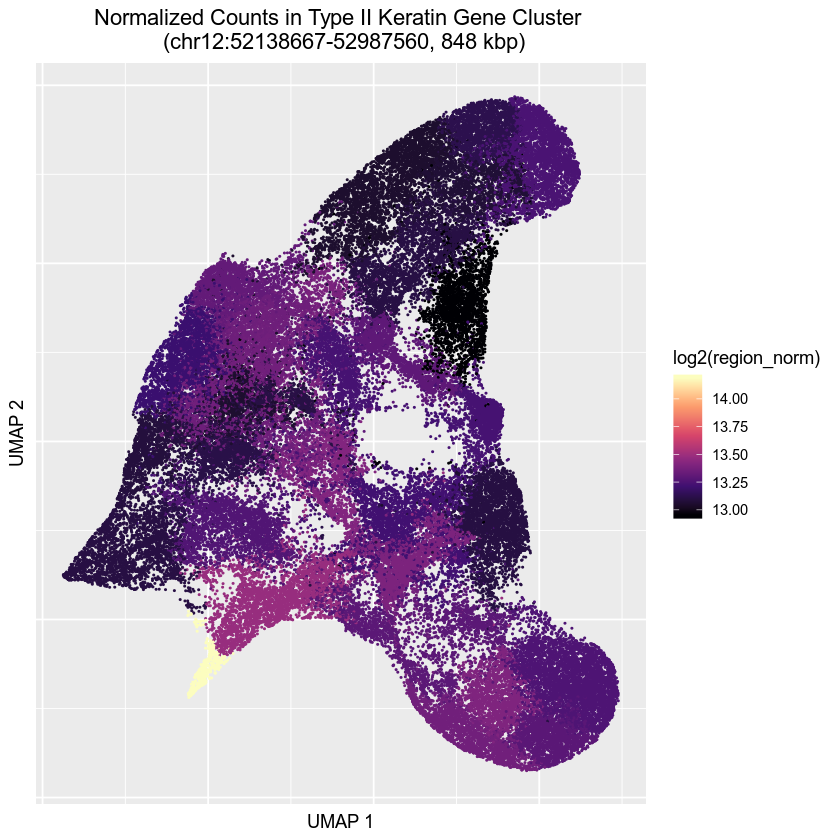

In [1402]:
options(repr.plot.width = 7, repr.plot.height = 7)

df = data.frame(x.sp@umap, region_norm=norm_reads_in_region[clusters])
# shuffle so days don't overlap
df = df[sample(dim(df)[1]), ]

ggplot(df) +
# ggplot(df[df$x.sp.sample %in% c("D14"), ]) +
geom_point(size=0.2, alpha=1, aes(x=umap.1 , y=umap.2, col=log2(region_norm))) +
ggtitle(sprintf("Normalized Counts in Type II Keratin Gene Cluster \n (%s, %d kbp)", region, 
               as.integer(width(region_gr)/1000))) + 
xlab("UMAP 1") + ylab("UMAP 2") +
scale_color_viridis_c(oob=squish, option = "A") +
theme(plot.title = element_text(hjust = 0.5),
     axis.ticks = element_blank(),
     axis.text =element_blank())

### Type 1 Interferon Locus

In [678]:
region = "chr9:21053568-21498318"
region_gr = GRanges(c(region))

In [679]:
norm_reads_in_region = colSums(norm_cts[unique(queryHits(findOverlaps(peaks_gr, region_gr))), ])

In [680]:
max(norm_reads_in_region)
median(norm_reads_in_region)
min(norm_reads_in_region)
max(norm_reads_in_region)/min(norm_reads_in_region)

[1] 3361.933

[1] 1736.506

[1] 1327.96

[1] 2.531652

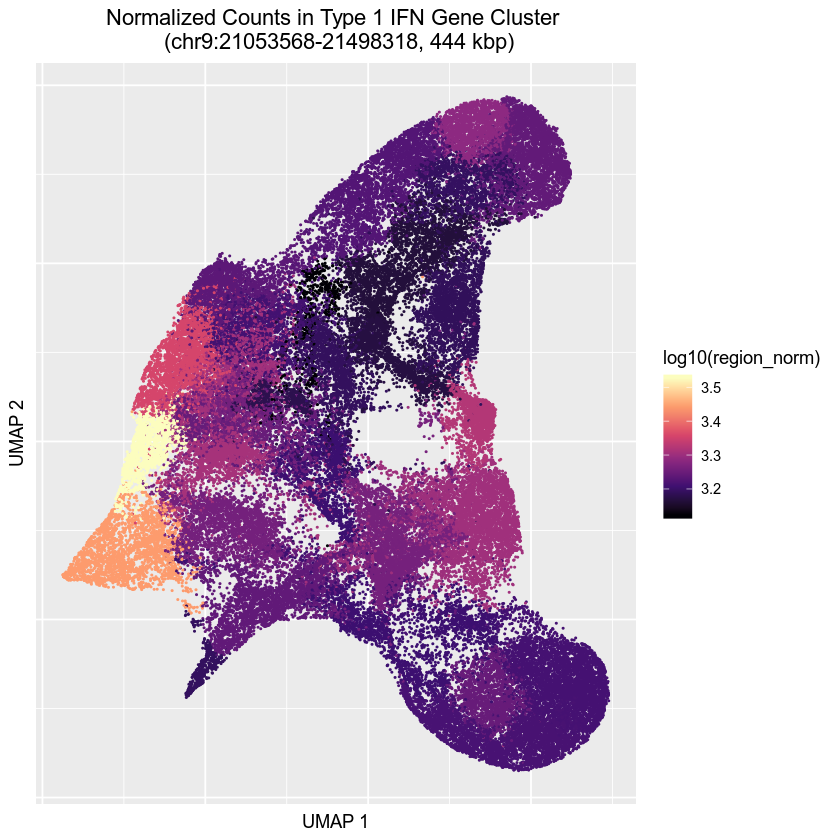

In [616]:
options(repr.plot.width = 7, repr.plot.height = 7)

df = data.frame(x.sp@umap, region_norm=norm_reads_in_region[clusters])
# shuffle so days don't overlap
df = df[sample(dim(df)[1]), ]

ggplot(df) +
# ggplot(df[df$x.sp.sample %in% c("D14"), ]) +
geom_point(size=0.2, alpha=1, aes(x=umap.1 , y=umap.2, col=log10(region_norm))) +
ggtitle(sprintf("Normalized Counts in Type 1 IFN Gene Cluster \n (%s, %d kbp)", region, 
               as.integer(width(region_gr)/1000))) + 
xlab("UMAP 1") + ylab("UMAP 2") +
scale_color_viridis_c(oob=squish, option = "A") +
theme(plot.title = element_text(hjust = 0.5),
     axis.ticks = element_blank(),
     axis.text =element_blank())

### Promoters of Olfactory Receptor Genes

In [135]:
prom.hg38 = promoters(genes.hg38, upstream = 2000, downstream = 500)
seqlevels(prom.hg38) = paste("chr", seqlevels(prom.hg38), sep='')

Warning message in valid.GenomicRanges.seqinfo(x, suggest.trim = TRUE):
"GRanges object contains 1 out-of-bound range located on sequence MT.
  Note that ranges located on a sequence whose length is unknown (NA) or
  on a circular sequence are not considered out-of-bound (use
  seqlengths() and isCircular() to get the lengths and circularity flags
  of the underlying sequences). You can use trim() to trim these ranges.
  See ?`trim,GenomicRanges-method` for more information."


In [1617]:
region_gr = prom.hg38[(grepl("^OR[0-9]", prom.hg38$gene_name)),]

In [1367]:
# total olfactory receptors 
length(region_gr)

# those that intersect with any peaks
length(unique(subjectHits(findOverlaps(peaks_gr, region_gr))))

[1] 471

[1] 35

In [1626]:
norm_reads_in_region = colSums(norm_cts[unique(queryHits(findOverlaps(peaks_gr, region_gr))), ])

In [1627]:
max(norm_reads_in_region)
median(norm_reads_in_region)
min(norm_reads_in_region)
max(norm_reads_in_region)/min(norm_reads_in_region)

[1] 1344.773

[1] 423.642

[1] 287.719

[1] 4.673912

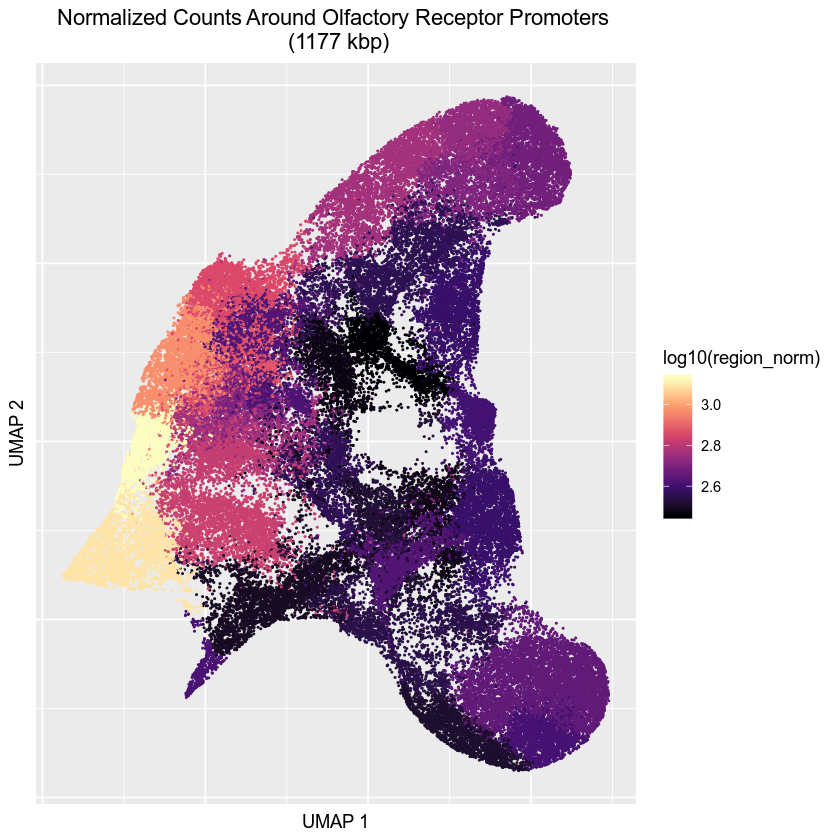

In [1628]:
options(repr.plot.width = 7, repr.plot.height = 7)

df = data.frame(x.sp@umap, region_norm=norm_reads_in_region[clusters])
# shuffle so days don't overlap
df = df[sample(dim(df)[1]), ]

ggplot(df) +
# ggplot(df[df$x.sp.sample %in% c("D14"), ]) +
geom_point(size=0.2, alpha=1, aes(x=umap.1 , y=umap.2, col=log10(region_norm))) +
ggtitle(sprintf("Normalized Counts Around Olfactory Receptor Promoters \n (%d kbp)", 
               as.integer(sum(width(region_gr))/1000))) + 
xlab("UMAP 1") + ylab("UMAP 2") +
scale_color_viridis_c(oob=squish, option = "A") +
theme(plot.title = element_text(hjust = 0.5),
     axis.ticks = element_blank(),
     axis.text =element_blank())

### Soufi et al "DBR" Heterochromatin Regions

These were regions identified in Soufi et al 2012 that were recfractory to OSKM binding in fibroblasts and are marked by H3K9me3, and are required for reprogramming. This can be done at single-cell level since it is 500 Mbp combined.

In [1828]:
region_gr = read.table("../../../resources/GSE36570/DBRs.hg38.bed")
colnames(region_gr) = c("chr", "start", "end")
region_gr = makeGRangesFromDataFrame(region_gr)

In [1829]:
norm_reads_in_region = Matrix::rowSums(x.sp@pmat[, unique(queryHits(findOverlaps(GRanges(as.character(x.sp@peak)), region_gr)))])/Matrix::rowSums(x.sp@pmat)

In [1830]:
max(norm_reads_in_region)
median(norm_reads_in_region)
min(norm_reads_in_region)
max(norm_reads_in_region)/min(norm_reads_in_region)

[1] 0.09594096

[1] 0.02569026

[1] 0.00228833

[1] 41.9262

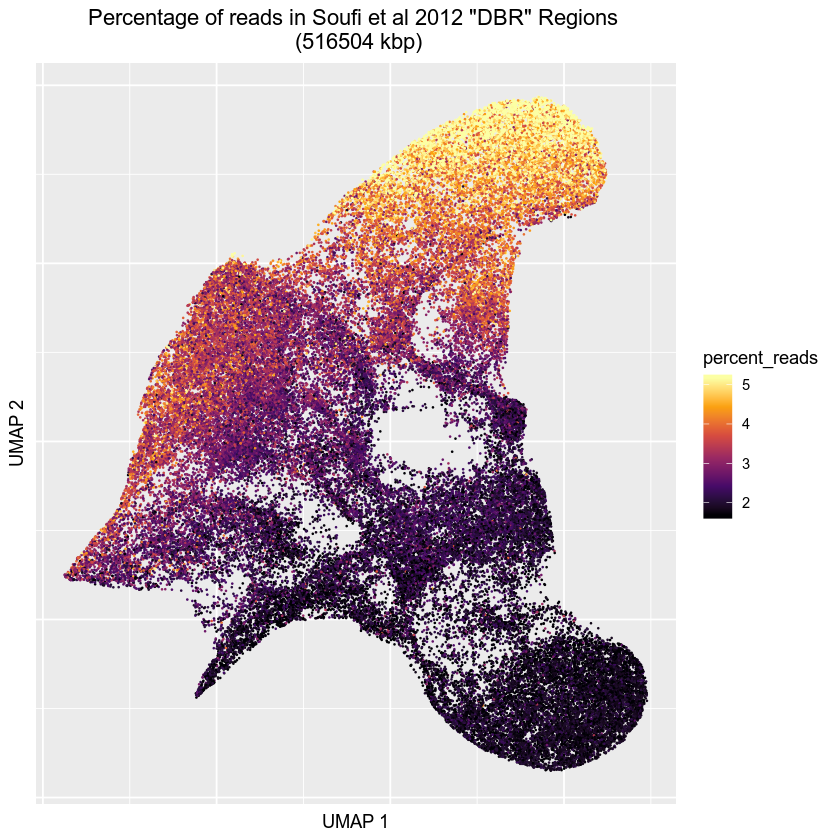

In [1831]:
options(repr.plot.width = 7, repr.plot.height = 7)

df = data.frame(x.sp@umap, percent_reads=100*norm_reads_in_region)
# shuffle so days don't overlap
df = df[sample(dim(df)[1]), ]

ggplot(df) +
# ggplot(df[df$x.sp.sample %in% c("D14"), ]) +
geom_point(size=0.1, alpha=1, aes(x=umap.1 , y=umap.2, col=percent_reads)) +
ggtitle(sprintf("Percentage of reads in Soufi et al 2012 \"DBR\" Regions \n (%d kbp)",  
               as.integer(sum(width(region_gr))/1000))) + 
xlab("UMAP 1") + ylab("UMAP 2") +
scale_color_viridis_c(limits=c(quantile(100*norm_reads_in_region, 0.1), 
                               quantile(100*norm_reads_in_region, 0.95)), 
                      oob=squish, option = "B") +
theme(plot.title = element_text(hjust = 0.5),
     axis.ticks = element_blank(),
     axis.text =element_blank())

### Reads in Clustered Peak Sets

In [47]:
pmatRowSums = Matrix::rowSums(x.sp@pmat)

In [1832]:
fnames = c("../20200307_fine_clustering/beds/20200330_gridmap_peakwidthnorm_n20/idx5.bed")
# fnames = c("../20200331_gc_stratify/beds/20200403_fibr_cluster6_lt_0.2_quantile_gc10/gc_0.1_0.32.bed",
#           "../20200331_gc_stratify/beds/20200403_fibr_cluster6_lt_0.2_quantile_gc10/gc_0.32_0.35.bed")
# fnames = c("./tmp.bed")
# fnames = list(gzfile("/oak/stanford/groups/akundaje/surag/GEO/GSE36570/croo/SRR445817/peak/idr_reproducibility/idr.optimal_peak.narrowPeak.gz"))

region_gr = read.table(fnames[[1]])

if (length(fnames)>1) {
    for (i in seq(2, length(fnames))) {
        region_gr = rbind(region_gr, read.table(fnames[[i]]))
    }
}
# region_gr = read.table("../20200304_transient_peaks/beds/20200305_heatmap_bulk_n15/idx1.bed")
# region_gr = read.table("./beds/20200328_tmp_n20/idx14.1000bp.bed")
colnames(region_gr) = c("chr", "start", "end")
region_gr = makeGRangesFromDataFrame(region_gr)

In [1833]:
# region_gr = GRanges((cur_diff_peaks)[1:10000])

In [1834]:
norm_reads_in_region = Matrix::rowSums(x.sp@pmat[, unique(queryHits(findOverlaps(GRanges(as.character(x.sp@peak)), region_gr)))])/pmatRowSums

In [1835]:
max(norm_reads_in_region)
median(norm_reads_in_region)
min(norm_reads_in_region)
max(norm_reads_in_region)/min(norm_reads_in_region)

[1] 0.1744349

[1] 0.002873039

[1] 0

[1] Inf

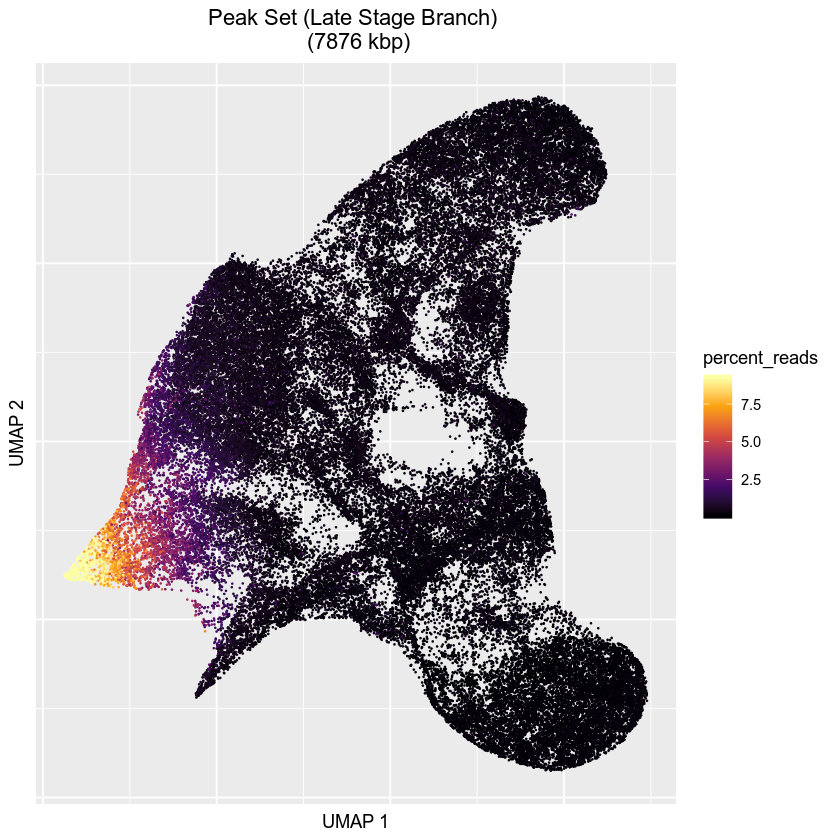

In [1861]:
options(repr.plot.width = 7, repr.plot.height = 7)

df = data.frame(x.sp@umap, percent_reads=100*norm_reads_in_region)
# shuffle so days don't overlap
df = df[sample(dim(df)[1]), ]

ggplot(df) +
# ggplot(df[df$percent_reads<2, ]) +
geom_point(size=0.1, alpha=1, aes(x=umap.1 , y=umap.2, col=percent_reads)) +
ggtitle(sprintf("Peak Set (Late Stage Branch) \n (%d kbp)",  
               as.integer(sum(width(region_gr))/1000))) + 
xlab("UMAP 1") + ylab("UMAP 2") +
scale_color_viridis_c(limits= c(quantile(100*norm_reads_in_region, 0.1), 
                              quantile(100*norm_reads_in_region, 0.995)), 
                      oob=squish, option = "B") +
theme(plot.title = element_text(hjust = 0.5),
     axis.ticks = element_blank(),
     axis.text =element_blank())

### Reads in One/Few Peaks 

In [2630]:
# is single or few bins
region = "chr17:31294646-31297435"
region_gr = GRanges(c(region))

In [2631]:
intersection_idxs = unique(queryHits(findOverlaps(GRanges(as.character(x.sp@peak)), region_gr)))
intersection_idxs

[1] 175213 175214

In [2632]:
# num_reads_in_region = x.sp@pmat[, intersection_idxs]
num_reads_in_region = Matrix::rowSums(x.sp@pmat[, intersection_idxs])

In [2633]:
max(num_reads_in_region)

[1] 3

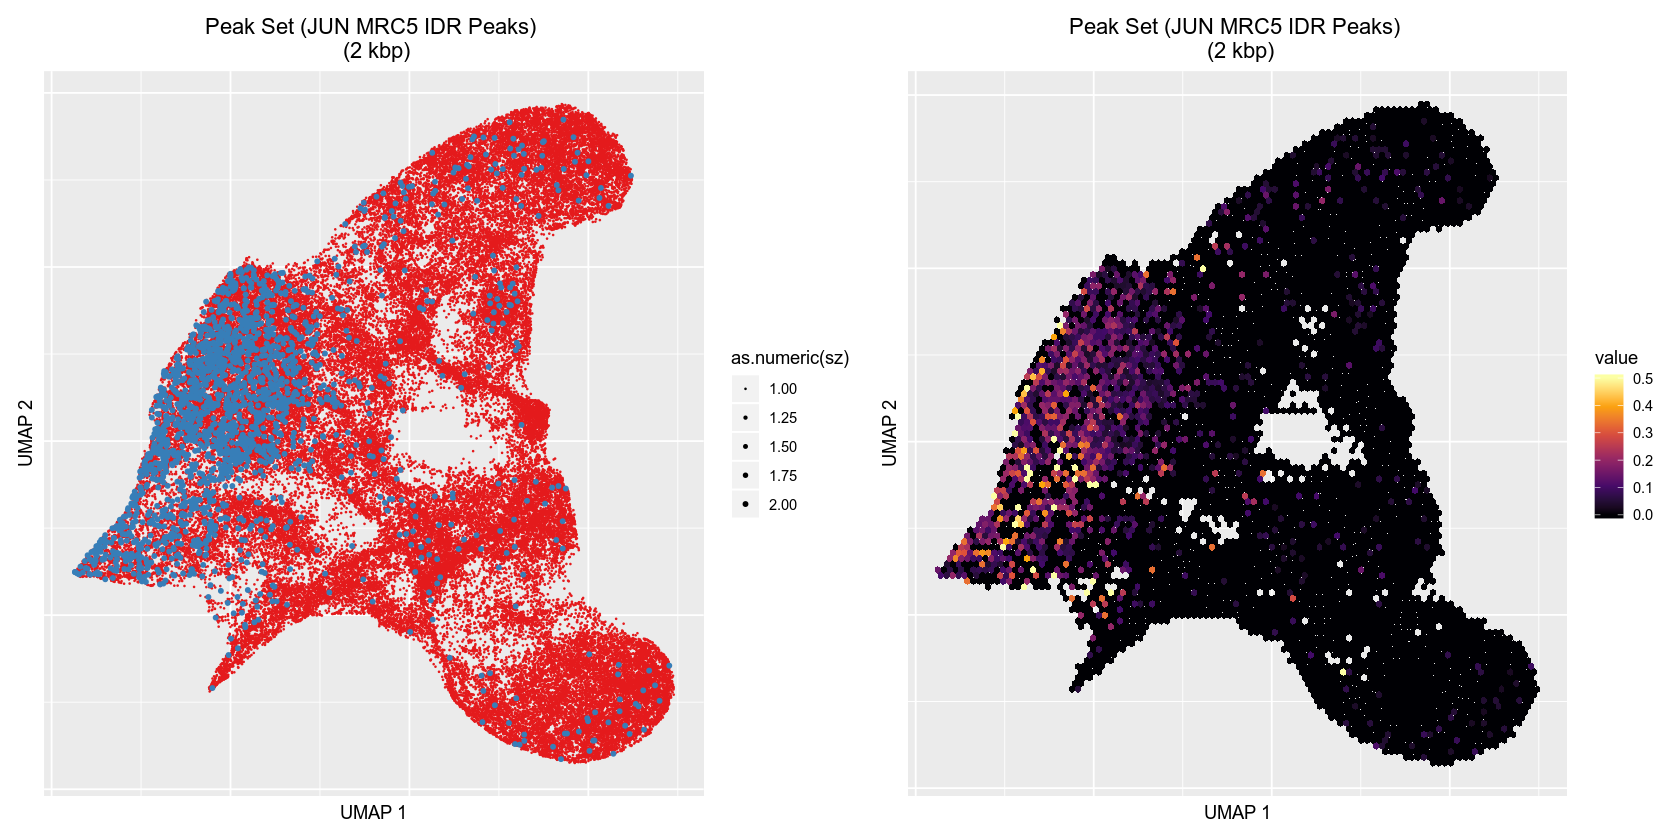

In [2635]:
df = data.frame(x.sp@umap, percent_reads=num_reads_in_region)
df$sz = ifelse(df$percent_reads>0, 2, 1)
# bring to top
df = df[order(df$percent_reads), ]

# BINARY READS: BIGGER DOTS FOR CELLS WITH >0 READ IN REGION
plot1 <- ggplot(df) +
# ggplot(df[df$percent_reads<2, ]) +
geom_point(alpha=1, aes(x=umap.1 , y=umap.2, col=percent_reads>0, size=as.numeric(sz))) +
ggtitle(sprintf("Peak Set (JUN MRC5 IDR Peaks) \n (%d kbp)",  
               as.integer(sum(width(region_gr))/1000))) + 
xlab("UMAP 1") + ylab("UMAP 2") +
# scale_color_viridis_c(limits= c(quantile(100*norm_reads_in_region, 0.1), 
#                                quantile(100*norm_reads_in_region, 0.95)), 
#                       oob=squish, option = "B") +
scale_color_brewer(breaks=DAYS, palette = "Set1") +
theme(plot.title = element_text(hjust = 0.5),
     axis.ticks = element_blank(),
     axis.text =element_blank())+
scale_size_continuous(range = c(0.1, 1))

df = data.frame(x.sp@umap, num_reads=num_reads_in_region)
df$sz = ifelse(df$num_reads>0, .2, 0.1)
# shuffle so days don't overlap
df = df[order(df$num_reads), ]
df_nonzero = df[df$num_reads>0, ]

# AGGREGATE READS: SUM RAW READS IN PEAKS IN UMAP SPACE 
plot2 <- ggplot(df, aes(x=umap.1 , y=umap.2, z=num_reads)) +
# geom_point(alpha=1, , size=0.1) +
stat_summary_hex(bins=100) +
# stat_bin2d(data=df_nonzero, aes(x=umap.1 , y=umap.2), bins=100) +
ggtitle(sprintf("Peak Set (JUN MRC5 IDR Peaks) \n (%d kbp)",  
               as.integer(sum(width(region_gr))/1000))) + 
xlab("UMAP 1") + ylab("UMAP 2") +
scale_fill_viridis_c(limits=c(0,.5), option="B", oob=squish) +
theme(plot.title = element_text(hjust = 0.5),
     axis.ticks = element_blank(),
     axis.text =element_blank())+
scale_size_continuous(range = c(0.1, .5))


options(repr.plot.width = 14, repr.plot.height = 7)
plot1 | plot2

### Colouring by Old Clusters

In [773]:
# using old metadata to annotate (these clusters were used to call peaks)

# Metadata file from previous run
# should contain, sample_barcode as rowname, sample, umap1, umap2, cluster
old_metaData = read.table("../20200122_snapATAC/snapATAC_sessions/20200125_n76770/metadata.tsv", header = T)
rownames(old_metaData) =  paste(old_metaData$sample, old_metaData$barcode, sep='_')
old_metaData = old_metaData[rownames(metaData), ]
head(old_metaData, 2)

barcode          cluster umap1    umap2    barcode.1       
D0_AAACAACGACGATTAC AAACAACGACGATTAC 6       2.515876 8.252824 AAACAACGACGATTAC
D0_AAACAACGACTCACGG AAACAACGACTCACGG 6       2.355841 7.403916 AAACAACGACTCACGG
                    TN    UM    PP    UQ    CM landmark cluster.1 sample
D0_AAACAACGACGATTAC 42629 38455 38381 33575 51 0        6         D0    
D0_AAACAACGACTCACGG  4424  4009  3998  3694  4 0        6         D0

In [774]:
sum(is.na(old_metaData$cluster.1))

[1] 330

Warning message:
"Removed 330 rows containing missing values (geom_point)."


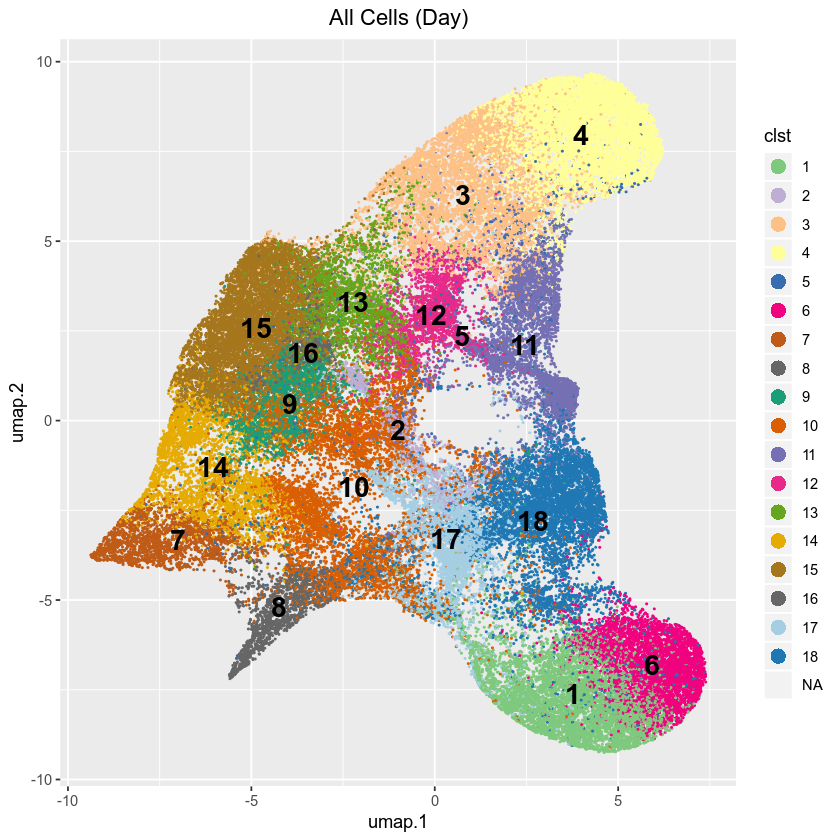

In [1283]:
options(repr.plot.width = 7, repr.plot.height = 7)

df = data.frame(x.sp@umap, clst=as.factor(old_metaData$cluster.1))
# shuffle so days don't overlap
df = df[sample(dim(df)[1]), ]

ggplot(df) +
# ggplot(df[df$x.sp.sample %in% c("D14"), ]) +
geom_point(size=0.2, alpha=1, aes(x=umap.1 , y=umap.2, col=clst)) +
# scale_color_brewer( palette = "Set1") +
scale_color_manual(values=col_vector) +
geom_text(data=data.frame(aggregate(x.sp@umap, list(old_metaData$cluster.1), mean)),
         aes(x=umap.1, y=umap.2, label=Group.1), size=6, fontface = "bold") +
ggtitle("All Cells (Day)") + 
theme(plot.title = element_text(hjust = 0.5)) +
#       legend.positio = "none")
guides(colour = guide_legend(override.aes = list(shape=16, alpha=1, size=4))) 

## D0 Diff Peaks

In [1728]:
data.use = cts[, c("cluster_1", "cluster_8")]
group = factor(colnames(data.use), levels = colnames(data.use))
design = model.matrix(~0+group)
y = DGEList(counts=data.use, group=group)
et = exactTest(y, dispersion = 0.4^2)
cur_diff_peaks = rownames(et$table[order((1/et$table$PValue)*ifelse(et$table$logFC>0, 1, -1)),])  

In [1113]:
frac_in_peakset = Matrix::rowSums(x.sp@pmat[, as.character(x.sp@peak) %in% cur_diff_peaks[1:10000]])/pmatRowSums

In [1114]:
frac_in_peakset_rev = Matrix::rowSums(x.sp@pmat[, as.character(x.sp@peak) %in% rev(cur_diff_peaks)[1:10000]])/pmatRowSums

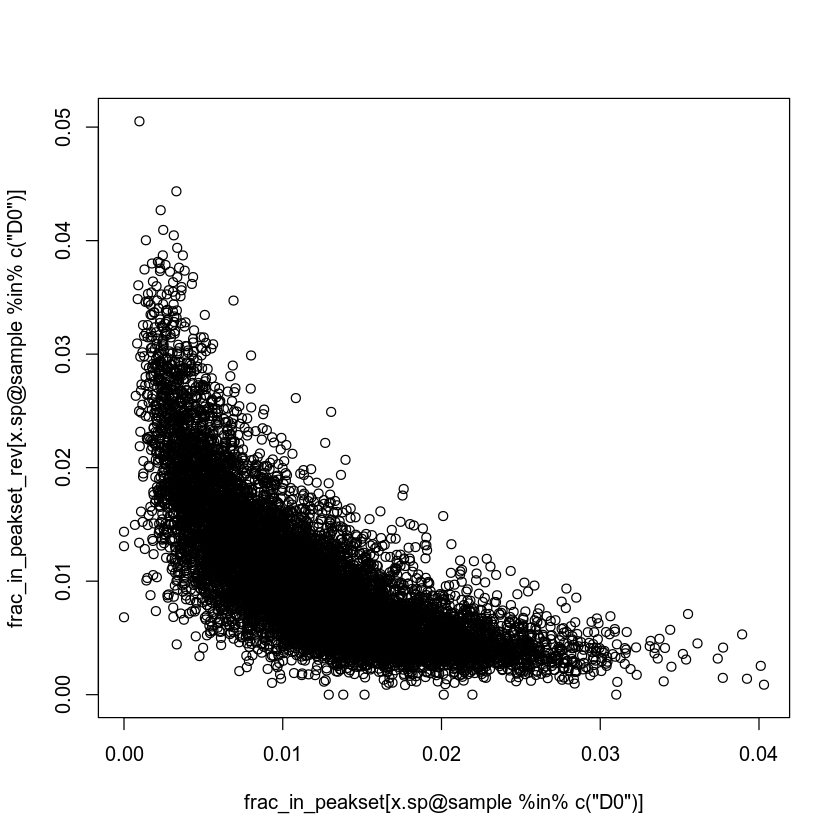

In [1115]:
plot(frac_in_peakset[x.sp@sample %in% c("D0")], frac_in_peakset_rev[x.sp@sample %in% c("D0")])

In [1723]:
options(repr.plot.width = 7, repr.plot.height = 7)
selected_cluster_id = 10

twoplots = list()
i=1
cur_days = DAYS #c("D0", "D2")
for (toplot in list(frac_in_peakset, frac_in_peakset_rev)) {

    # df = data.frame(x.sp@umap, accs=km_mb$centroids[selected_cluster_id, ][clusters])
    cur_selected = toplot[x.sp@sample %in% cur_days]
    cur_med = quantile(cur_selected, 0.5)

    # or a specific peak
    # df = data.frame(x.sp@umap, accs=log2(1+colSums(norm_cts[rev(cur_diff_peaks)[1:1000], ]))[clusters])
    df = data.frame(x.sp@umap, x.sp@sample, frip=toplot)
    # shuffle so days don't overlap
    df = df[sample(dim(df)[1]), ]

    # ggplot(df) +
    twoplots[[i]] <- ggplot(df[df$x.sp.sample %in% cur_days, ]) +
    geom_point(size=0.1, alpha=1, aes(x=umap.1 , y=umap.2, col=frip)) +
    ggtitle(sprintf("Fraction of Reads in Peak Set %d (per cell)", i)) + 
    xlab("UMAP 1") + ylab("UMAP 2") +
    scale_color_viridis_c(limits=c(quantile(cur_selected, 0.1), 
                                   quantile(cur_selected, 0.99)), oob=squish, option = "A") +
    theme(plot.title = element_text(hjust = 0.5))
    
    i = i+1
}

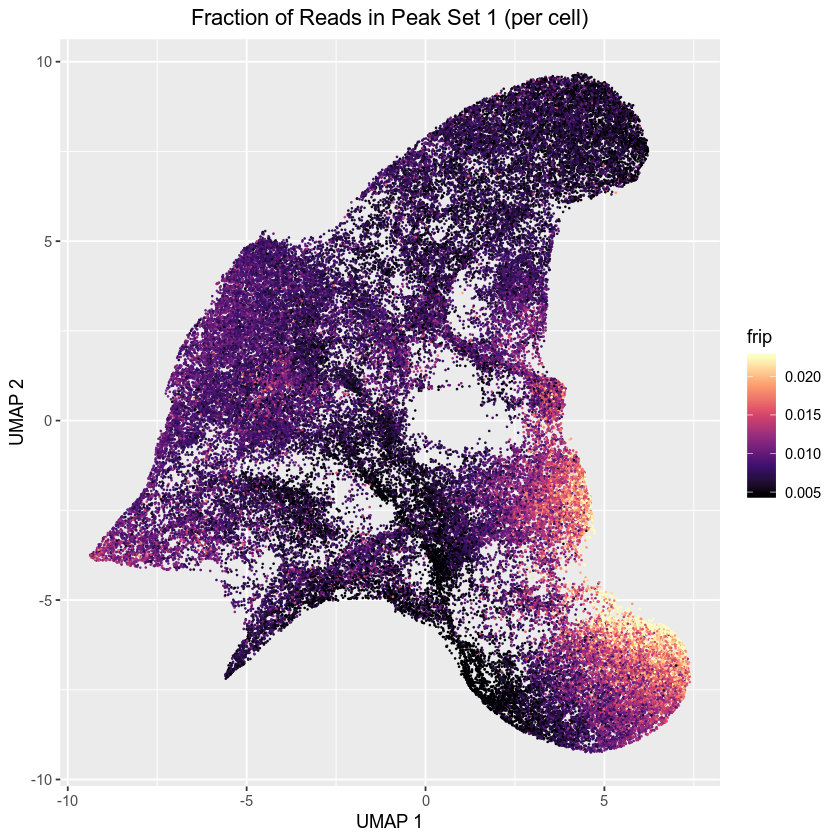

In [1726]:
options(repr.plot.width = 7, repr.plot.height = 7)
twoplots[[1]]

In [1840]:
sum(x.sp@pmat[1:10, 1:1000])

[1] 274